# Unit 5 - Financial Planning

In [137]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [3]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [104]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [105]:
# Fetch current BTC price
btc_price = requests.get(btc_url).json()['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_price = requests.get(eth_url).json()['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $24494.40
The current value of your 5.3 ETH is $5851.15


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [50]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [58]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [60]:
# Format current date as ISO format
date = '2022-06-17'

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_ticker = alpaca.get_bars(
    tickers,
    timeframe,
    start=date,
    end=date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_ticker[df_ticker['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_ticker[df_ticker['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Preview DataFrame
df_ticker

AGG                                              \
                             open    high    low   close   volume trade_count   
timestamp                                                                       
2022-06-17 04:00:00+00:00  100.42  100.57  99.98  100.34  9891839       26374   

                                         SPY                          \
                                vwap    open    high     low   close   
timestamp                                                              
2022-06-17 04:00:00+00:00  100.37265  365.43  369.38  362.17  365.86   

                                                              
                              volume trade_count        vwap  
timestamp                                                     
2022-06-17 04:00:00+00:00  109255759      821350  366.263193

In [98]:
# Pick AGG and SPY close prices
agg_close_price = float(df_ticker['AGG']['close'].values)
spy_close_price = float(df_ticker['SPY']['close'].values)


# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $100.34
Current SPY closing price: $365.86


In [101]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $18293.00
The current value of your 200 AGG shares is $20068.00


### Savings Health Analysis

In [156]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
savings_data = my_btc_value + my_eth_value, my_agg_value + my_spy_value


# Create savings DataFrame
df_savings = pd.DataFrame()

index = ('crypto', 'shares')
df_savings.index = index

df_savings['amount'] = savings_data

# Display savings DataFrame
display(df_savings)

,amount
crypto,30345.547
shares,38361.000


<AxesSubplot:title={'center':'Savings Portfolio'}, ylabel='amount'>

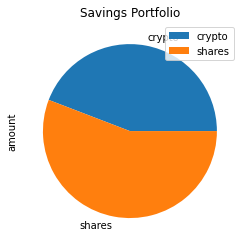

In [158]:
# Plot savings pie chart
df_savings.plot.pie(y=0, title='Savings Portfolio')

In [164]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount'].sum()

goal = emergency_fund - total_savings

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations, you have more than enough money in this fund!")
elif total_savings == emergency_fund:
    print('Congratulations, your fund has reached your desired amount.')
else:
    print(f'You do not have enough money in this fund - you are ${goal} from your goal')

Congratulations, you have more than enough money in this fund!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [167]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [169]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date  
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis=1)
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis=1)


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY],axis=1, keys=['AGG','SPY'])

# Display sample data
df_stock_data.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2016-05-02 04:00:00+00:00       15119  110.627199  206.90  208.18  206.41   
2016-05-03 04:00:00+00:00       15662  110.865995  206.50  206.80  205.28   
2016-05-04 04:00:00+00:00       13982  110.879063  205.00  205.85  204.42   
2016-05-05 04:00:00+00:00       15707  111.028363  205.57  205.98  204.47   
2016-05-06 04:00:00+00:00       12697  111.031967  204.04  205.77  203.88   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2016-05-02 04:00:00+00:00  208.03   61908515      263580  207.294812  
2016-05-03 04:00:00+00:00  206.13  106422142      377518  206.312060  
2016-05-04 04:00:00+00:00  204.96   92199810      345261  205.090172  
2016-05-05 04:00:00+00:00  204.95   67597222      280622  205.141555  
2016-05-06 04:00:00+00:00  205.70   89131004      340335  204.937074

In [186]:
tickers

['AGG', 'SPY']

In [191]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
num_sims = 500
trading_days = 252*30
weights = [0.40, 0.60]

MC = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = num_sims,
    num_trading_days = trading_days
)

In [193]:
# Printing the simulation input data
print(f'This Monte Carlo simulation will use 5 years of historical data from AGG and SPY, to forecast a portfolio with the weights of {weights} respectively in each stock, for {trading_days} days by running {num_sims} simulations.')

This Monte Carlo simulation will use 5 years of historical data from AGG and SPY, to forecast a portfolio with the weights of [0.4, 0.6] respectively in each stock, for 7560 days by running 500 simulations.


In [175]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/michael1/Documents/FinTech/Week 5/module_5_challenge/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003240,0.995636,0.995314,1.001043,0.991670,1.005000,0.997239,1.000460,1.006812,1.005245,...,0.995277,1.009217,1.001552,0.996012,1.005289,1.009443,1.004713,1.003058,1.007415,1.005968
2,1.017888,0.991704,1.007078,1.000748,0.995287,0.999290,0.995729,1.007679,1.021629,1.005220,...,0.996841,1.011398,0.991143,0.995993,1.002668,1.015464,1.003537,0.995636,1.003645,0.993084
3,1.013170,0.979209,1.010148,1.008215,0.993243,0.999714,0.996589,1.003087,1.012824,1.005121,...,1.006484,1.005967,0.986620,0.996371,1.008183,1.017445,0.997855,0.992500,0.993691,0.981029
4,0.999796,0.978628,1.021494,1.016413,0.994845,0.999881,0.994039,1.008362,1.004665,1.007878,...,1.005231,1.001133,0.985042,0.998002,1.008924,1.024578,0.992867,0.998460,0.985793,0.978721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,10.598406,7.803618,4.087607,21.301889,9.541481,8.960672,4.391186,9.697695,3.613083,10.010255,...,21.455750,5.382984,7.610238,14.015635,8.047081,10.394754,11.629652,9.510974,4.097954,9.681120
7557,10.537091,7.815143,4.102962,21.192498,9.592906,8.989156,4.441098,9.759346,3.637988,10.086944,...,21.401443,5.392663,7.609665,14.172406,7.981550,10.416083,11.717221,9.631665,4.084489,9.737751
7558,10.530461,7.822761,4.103251,21.084642,9.673204,9.035290,4.363157,9.741539,3.627483,10.036692,...,21.332375,5.372214,7.591180,14.132756,7.987819,10.424933,11.667823,9.647165,4.044766,9.725961
7559,10.575411,7.889081,4.063213,21.265920,9.638524,9.105901,4.375492,9.732571,3.597835,10.048694,...,21.614328,5.311152,7.595227,14.154533,7.942965,10.297867,11.678733,9.595967,4.026308,9.762513


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

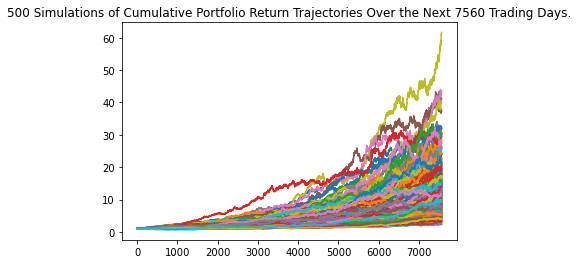

In [179]:
# Plot simulation outcomes
MC.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

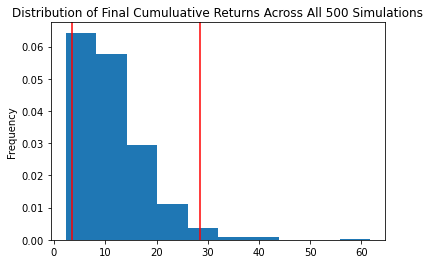

In [178]:
# Plot probability distribution and confidence intervals
MC.plot_distribution()

### Retirement Analysis

In [180]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean             11.508077
std               6.846488
min               2.290083
25%               6.693227
50%               9.822592
75%              14.679434
max              61.702664
95% CI Lower      3.448818
95% CI Upper     28.510118
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [181]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*20000,2)
ci_upper = round(tbl[9]*20000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $68976.37 and $570202.36


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [182]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*20000,2)
ci_upper = round(tbl[9]*20000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $68976.37 and $570202.36


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [208]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.80, 0.20],
    num_simulation = 300,
    num_trading_days = 252*5
)

In [209]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/michael1/Documents/FinTech/Week 5/module_5_challenge/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994738,1.000428,1.001680,1.000300,0.998570,0.997981,0.999229,0.999466,0.997587,0.999423,...,1.000799,1.005570,1.002226,1.006528,1.004507,0.997534,1.004348,1.001278,0.998622,1.001530
2,0.997917,1.003787,1.003935,1.001587,0.998642,0.995236,0.991412,0.996476,0.992131,1.003537,...,1.003235,1.007520,0.997890,1.002403,1.006019,0.997242,1.000734,1.001269,0.993694,1.000134
3,0.996772,0.993714,1.005794,1.004563,1.000179,0.990744,0.987527,0.997139,0.991162,1.001669,...,1.001549,1.003229,0.998434,1.004456,1.007579,1.000009,1.001397,1.002592,0.994425,0.999505
4,0.991148,0.991506,1.003865,1.005446,1.002290,0.986672,0.988475,1.000580,0.991271,0.999742,...,1.000500,1.004897,0.997003,1.003927,1.007931,1.002856,1.004316,1.006172,0.986863,0.995543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.177738,1.255191,1.004854,1.286322,1.154404,0.892069,1.144218,1.194346,1.108663,1.189636,...,1.314015,1.111696,1.070423,1.225178,1.553881,1.300446,1.088376,1.224097,1.241937,1.340528
1257,1.174541,1.253926,1.005654,1.285189,1.151135,0.890576,1.144909,1.197240,1.109524,1.188072,...,1.313849,1.117416,1.065632,1.228767,1.546235,1.298374,1.088801,1.227349,1.242487,1.343691
1258,1.168961,1.257349,1.002532,1.288200,1.151643,0.887008,1.141281,1.203167,1.108263,1.186512,...,1.321093,1.122335,1.063485,1.230151,1.543243,1.300038,1.091042,1.227250,1.245416,1.337484
1259,1.168821,1.255738,1.004406,1.283318,1.150721,0.892532,1.145472,1.203235,1.109759,1.188988,...,1.322597,1.125282,1.063506,1.235706,1.549848,1.294829,1.088698,1.227599,1.243909,1.336421


<AxesSubplot:title={'center':'300 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

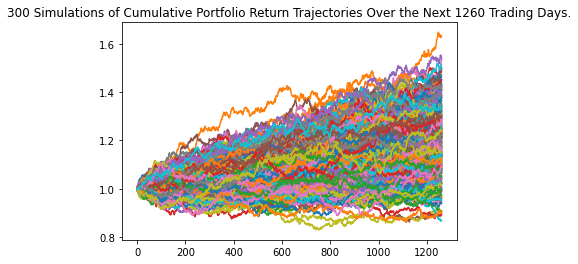

In [210]:
# Plot simulation outcomes
MC_5_years.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 300 Simulations'}, ylabel='Frequency'>

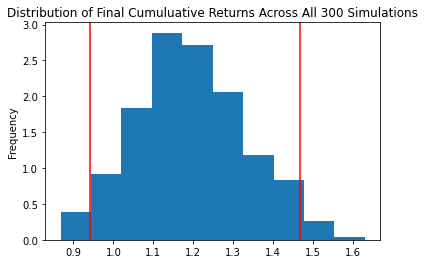

In [211]:
# Plot probability distribution and confidence intervals
MC_5_years.plot_distribution()

In [212]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl5 = MC_5_years.summarize_cumulative_return()

# Print summary statistics
print(tbl5)

count           300.000000
mean              1.195512
std               0.137546
min               0.867581
25%               1.102516
50%               1.190527
75%               1.289212
max               1.629549
95% CI Lower      0.941259
95% CI Upper      1.468275
Name: 1260, dtype: float64


In [215]:
# Set initial investment
initial_investment_5 = 100000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_5 = round(tbl5[8]*100000,2)
ci_upper_5 = round(tbl5[9]*100000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_5} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_5} and ${ci_upper_5}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 5 years will end within in the range of $94125.89 and $146827.49


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004461,1.003269,0.998934,0.996767,1.000906,0.999279,0.995262,1.005752,0.993466,0.993655,...,1.001427,1.004350,0.996932,0.996844,0.997507,1.003457,0.998736,1.001195,0.999904,1.010218
2,1.007901,1.003304,0.993812,0.999973,1.000910,1.002347,0.996311,1.007234,0.993550,0.991021,...,0.997379,1.001952,0.998124,0.998063,1.001733,1.000273,0.994865,1.000109,0.994648,1.007838
3,1.007532,1.001077,0.990963,0.998339,1.001779,1.003653,0.994439,1.012230,0.999170,0.996484,...,0.995265,1.001745,0.995332,1.003023,1.003800,0.999755,0.997616,1.004730,0.993391,1.010444
4,1.020339,1.005743,0.991869,0.998218,1.005630,1.008717,0.987764,1.012750,0.999227,0.996474,...,0.999028,1.004730,0.995357,1.000204,1.008738,0.999273,0.999426,1.003776,0.991478,1.013379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.616922,1.761703,1.143430,1.687801,1.743826,1.174891,1.514199,2.447129,1.589765,1.570578,...,1.316494,1.863650,1.727959,1.411033,1.804671,1.500605,1.413278,1.552375,1.318340,1.960015
2517,1.620285,1.769184,1.145132,1.695693,1.742878,1.175745,1.517697,2.441471,1.586174,1.560826,...,1.318463,1.857860,1.724003,1.409092,1.810136,1.499466,1.413210,1.552539,1.316872,1.956776
2518,1.622141,1.771927,1.149019,1.691589,1.739420,1.178965,1.522624,2.444413,1.580680,1.566154,...,1.317147,1.864694,1.727503,1.419561,1.821212,1.492831,1.412283,1.556659,1.318842,1.961271
2519,1.628885,1.770207,1.149670,1.703935,1.738053,1.182429,1.519485,2.441360,1.565663,1.576607,...,1.307985,1.858986,1.728039,1.430017,1.814690,1.496851,1.409284,1.562660,1.324798,1.964190


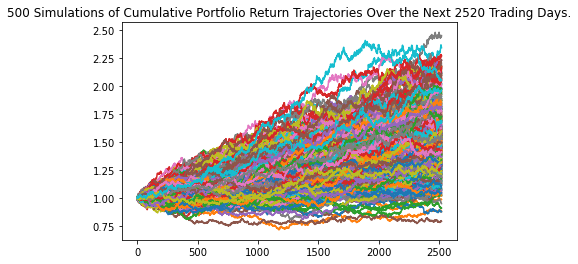

In [32]:
# Plot simulation outcomes
# YOUR CODE HERE!

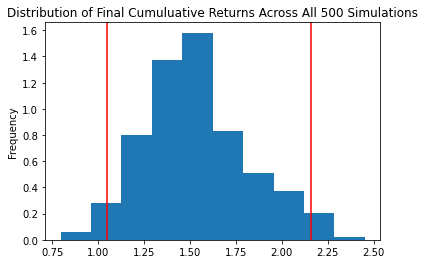

In [33]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.537014
std               0.282192
min               0.795263
25%               1.339641
50%               1.523799
75%               1.693927
max               2.451787
95% CI Lower      1.049781
95% CI Upper      2.159935
Name: 2520, dtype: float64


In [35]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $62986.85 and $129596.12
